<a href="https://colab.research.google.com/github/MinabutdinovAlmaz/MlPython/blob/main/MinabutdinovAA_4405_lab7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Сегментация MNIST на простой U-Net

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Загрузка данных (пример с использованием синтетических данных)
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Нормализация данных
x_train = x_train / 255.0
x_test = x_test / 255.0
y_train = y_train / 255.0
y_test = y_test / 255.0

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [3]:
print(y_test)

[0.02745098 0.00784314 0.00392157 ... 0.01568627 0.01960784 0.02352941]


In [4]:
# Создаем бинарные маски для каждого изображения
# если значение пикселя > 0.6, то считаем что это цифра и закрашиваем
# пиксель в маске, где цифра — 1, фон — 0
y_train_masks = np.where(x_train > 0.6, 1, 0).astype(np.float32)
y_test_masks = np.where(x_test > 0.6, 1, 0).astype(np.float32)


In [5]:
print(y_test_masks)

[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 ...

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]


In [6]:
#debug
i = 1000 #номер цифры из массива (всего от 0 до 59999)
print("Shape of x_train:", x_train.shape)
print("Shape of x_test:", x_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)
print("Shape of y_train masks:", y_train_masks.shape)
print("Shape of y_test masks:", y_test_masks.shape)
#print("Example mask:\n", y_train_masks[0,:,:,:])

Shape of x_train: (60000, 28, 28)
Shape of x_test: (10000, 28, 28)
Shape of y_train: (60000,)
Shape of y_test: (10000,)
Shape of y_train masks: (60000, 28, 28)
Shape of y_test masks: (10000, 28, 28)


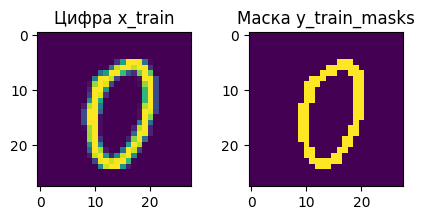

In [7]:
fig = plt.figure(figsize=(5, 2))
plt.subplot(1,2,1)
plt.imshow(x_train[i, :, :])#, 0])
plt.title("Цифра x_train")
plt.subplot(1,2,2)
plt.imshow(y_train_masks[i, :, :])#, 0])#, cmap='gray')
plt.title("Маска y_train_masks")
plt.show()

In [8]:
# Создание модели U-Net
def unet_model(input_shape):
    inputs = layers.Input(shape=input_shape)

    # Downsample
    conv1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    pool1 = layers.MaxPooling2D((2, 2))(conv1)

    conv2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    pool2 = layers.MaxPooling2D((2, 2))(conv2)

    # Upsample
    up1 = layers.UpSampling2D((2, 2))(pool2)
    concat1 = layers.concatenate([up1, conv2], axis=-1)
    conv3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(concat1)

    up2 = layers.UpSampling2D((2, 2))(conv3)
    concat2 = layers.concatenate([up2, conv1], axis=-1)
    conv4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(concat2)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(conv4)

    model = models.Model(inputs, outputs)
    return model

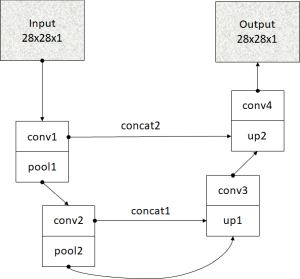

In [9]:
# Создание и компиляция модели
model = unet_model((28, 28, 1))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [10]:
# Обучение модели
model.fit(x_train[..., np.newaxis], y_train_masks, epochs=5, validation_data=(x_test[..., np.newaxis], y_test_masks))

Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 24s 10ms/step - accuracy: 0.9920 - loss: 0.0268 - val_accuracy: 0.9992 - val_loss: 0.0024
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 36s 9ms/step - accuracy: 0.9991 - loss: 0.0024 - val_accuracy: 0.9995 - val_loss: 0.0015
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 18s 9ms/step - accuracy: 0.9993 - loss: 0.0017 - val_accuracy: 0.9997 - val_loss: 0.0012
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 19s 10ms/step - accuracy: 0.9995 - loss: 0.0013 - val_accuracy: 0.9994 - val_loss: 0.0012
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - accuracy: 0.9997 - loss: 9.2293e-04 - val_accuracy: 0.9998 - val_loss: 6.5167e-04


In [11]:
# Оценка модели
test_loss, test_acc = model.evaluate(x_test[..., np.newaxis], y_test_masks)
print(f"Точность на тестовых данных: {test_acc}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9998 - loss: 6.6091e-04
Точность на тестовых данных: 0.999840259552002


In [12]:
# Функция для визуализации результатов
def visualize_segmentation(model, x_test, true_labels, num_images=5):
    predicted_labels = predictions[:,:,:,0]

    plt.figure(figsize=(15, 3 * num_images))
    for i in range(num_images):
        #генерация случайного индекса цифры из набора
        index = np.random.randint(0, len(x_test))

        # Оригинальное изображение
        plt.subplot(num_images, 3, 3 * i + 1)
        plt.imshow(x_test[index], cmap='gray')
        plt.title("Оригинал")
        plt.axis('off')

        # Истинная метка
        plt.subplot(num_images, 3, 3 * i + 2)
        plt.imshow(true_labels[index], cmap='gray')
        plt.title("Истинная маска")
        plt.axis('off')

        # Предсказанная метка
        plt.subplot(num_images, 3, 3 * i + 3)
        plt.imshow(predicted_labels[index], cmap='gray')
        plt.title("Предсказанная маска")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [13]:
#предсказание масок из валидационного набора
predictions = model.predict(x_test[..., np.newaxis])

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


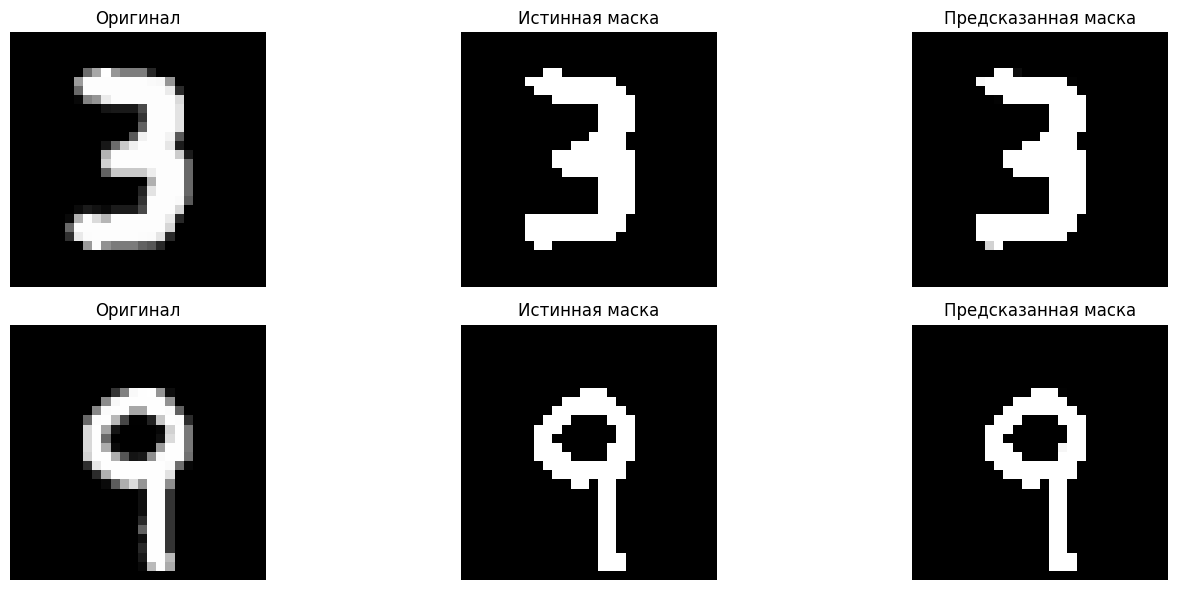

In [14]:
# Визуализация
visualize_segmentation(predictions, x_test, y_test_masks, num_images=2)

**Сегментация изображений из датасета Oxford-IIIT Pets**
Oxford-IIIT Pet Dataset: https://www.robots.ox.ac.uk/~vgg/data/pets/
Оригинальный пример кода: https://colab.research.google.com/github/margaretmz/image-segmentation/blob/main/unet_pet_segmentation.ipynb#scrollTo=ajAbpevhSHO7

Обучение на GPU занимает 11 минут для 7 эпох.

На CPU лучше не запускать - ОЧЕНЬ ДОЛГО

Рекомендуется 20 эпох

In [15]:
!pip install tensorflow_datasets==4.9.3
import tensorflow as tf
from tensorflow.keras import layers, models
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 4.6 MB/s eta 0:00:00
  Attempting uninstall: tensorflow_datasets
    Found existing installation: tensorflow-datasets 4.9.9
    Uninstalling tensorflow-datasets-4.9.9:
      Successfully uninstalled tensorflow-datasets-4.9.9


In [16]:
# гиперпараметры
IMG_WIDTH = 128
IMG_HEIGHT = 128
NUM_CLASSES = 3  # Oxford Pets - 3 класса (передний план, фон, граница)
BATCH_SIZE = 32
EPOCHS = 20

In [17]:
# Загрузка датасета средствами tensorflow
dataset, info = tfds.load('oxford_iiit_pet', with_info=True)
print(info)
#В этом датасете только три класса: передний план (питомец), фон и граница.

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/3680 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteKOJQ77/oxford_iiit_pet-train.tfrecord*...:…

Generating test examples...:   0%|          | 0/3669 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteKOJQ77/oxford_iiit_pet-test.tfrecord*...: …

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.
tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    full_name='oxford_iiit_pet/3.2.0',
    description="""
    The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
    images for each class. The images have large variations in scale, pose and
    lighting. All images have an associated ground truth annotation of breed.
    """,
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    data_dir=PosixGPath('/tmp/tmpe9fvefystfds'),
    file_format=tfrecord,
    download_size=773.52 MiB,
    dataset_size=774.69 MiB,
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=string),
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=37),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=uint8),
        'species': ClassLabel

In [18]:
print(dataset)

{'train': <_PrefetchDataset element_spec={'file_name': TensorSpec(shape=(), dtype=tf.string, name=None), 'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'segmentation_mask': TensorSpec(shape=(None, None, 1), dtype=tf.uint8, name=None), 'species': TensorSpec(shape=(), dtype=tf.int64, name=None)}>, 'test': <_PrefetchDataset element_spec={'file_name': TensorSpec(shape=(), dtype=tf.string, name=None), 'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'segmentation_mask': TensorSpec(shape=(None, None, 1), dtype=tf.uint8, name=None), 'species': TensorSpec(shape=(), dtype=tf.int64, name=None)}>}


In [19]:
print(dataset["train"])

<_PrefetchDataset element_spec={'file_name': TensorSpec(shape=(), dtype=tf.string, name=None), 'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'segmentation_mask': TensorSpec(shape=(None, None, 1), dtype=tf.uint8, name=None), 'species': TensorSpec(shape=(), dtype=tf.int64, name=None)}>


In [20]:
def resize(input_image, input_mask):
    input_image = tf.image.resize(input_image, (IMG_HEIGHT, IMG_WIDTH), method="nearest")
    input_mask = tf.image.resize(input_mask, (IMG_HEIGHT, IMG_WIDTH), method="nearest")
    return input_image, input_mask

In [21]:
def augment(input_image, input_mask):
    if tf.random.uniform(()) > 0.5:
        # Random flipping of the image and mask
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)
    return input_image, input_mask

In [22]:
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask -= 1 # Маски должны начинаться с 0.  В oxford_iiit_pet маски 1, 2, 3.
    return input_image, input_mask

In [23]:
def load_image_train(datapoint):
    input_image, input_mask = resize(datapoint['image'], datapoint['segmentation_mask'])
    input_image, input_mask = augment(input_image, input_mask)
    input_image, input_mask = normalize(input_image, input_mask)
    return input_image, input_mask

In [24]:
def load_image_test(datapoint):
    input_image, input_mask = resize(datapoint['image'], datapoint['segmentation_mask'])
    input_image, input_mask = normalize(input_image, input_mask)
    return input_image, input_mask

In [25]:
# подготовка данных
TRAIN_LENGTH = info.splits['train'].num_examples
TEST_LENGTH = info.splits['test'].num_examples

train_dataset = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = dataset['test'].map(load_image_test, num_parallel_calls=tf.data.AUTOTUNE)

train_dataset = train_dataset.cache().shuffle(TRAIN_LENGTH).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
VALIDATION_STEPS = TEST_LENGTH // BATCH_SIZE

In [26]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ["Input Image", "True Mask", "Predicted Mask"]

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis("off")
  plt.show()

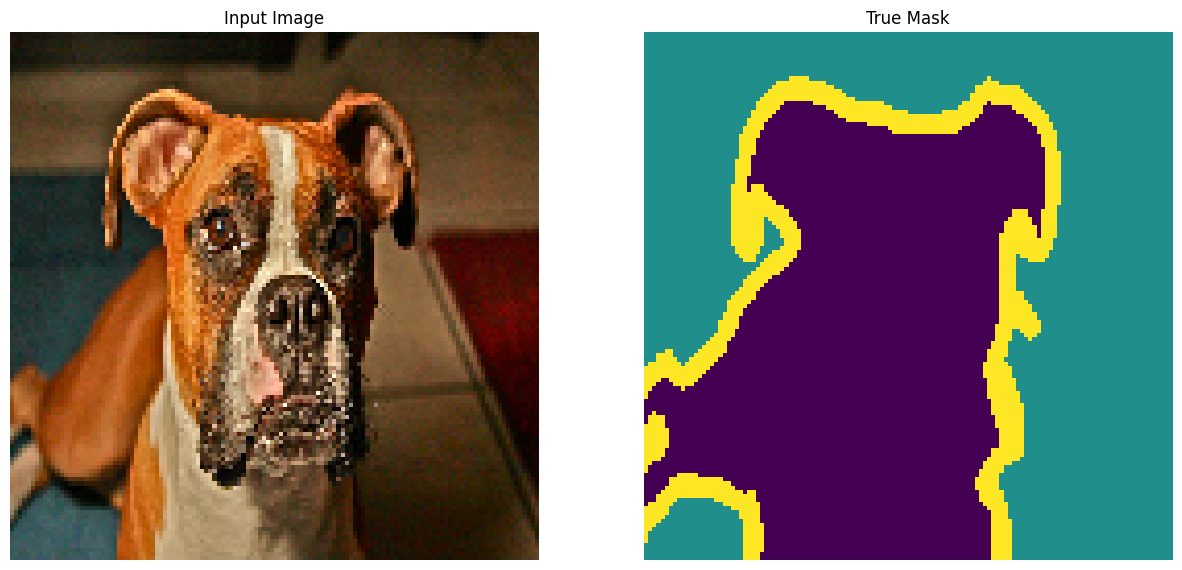

In [27]:
sample_batch = next(iter(test_dataset))
random_index = np.random.choice(sample_batch[0].shape[0])
sample_image, sample_mask = sample_batch[0][random_index], sample_batch[1][random_index]
display([sample_image, sample_mask])

In [28]:
# U-Net Архитектура
def build_unet(img_width, img_height, num_classes):
    inputs = tf.keras.Input(shape=(img_width, img_height, 3))

    # Encoder
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D((2, 2))(conv1)

    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D((2, 2))(conv2)

    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = layers.MaxPooling2D((2, 2))(conv3)

    # Bottleneck
    conv4 = layers.Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = layers.Conv2D(512, 3, activation='relu', padding='same')(conv4)

    # Decoder
    up5 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv4)
    #merge5 = layers.concatenate([conv3, up5], axis=3)
    conv5 = layers.Conv2D(256, 3, activation='relu', padding='same')(up5)
    conv5 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv5)

    up6 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv5)
    #merge6 = layers.concatenate([conv2, up6], axis=3)
    conv6 = layers.Conv2D(128, 3, activation='relu', padding='same')(up6)
    conv6 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv6)

    up7 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv6)
    #merge7 = layers.concatenate([conv1, up7], axis=3)
    conv7 = layers.Conv2D(64, 3, activation='relu', padding='same')(up7)
    conv7 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv7)

    # Output Layer
    outputs = layers.Conv2D(num_classes, 1, activation='softmax')(conv7)

    model = models.Model(inputs=inputs, outputs=outputs)
    return model

In [29]:
# Определение модели, функции потерь и оптимизатора
unet_model = build_unet(IMG_WIDTH, IMG_HEIGHT, NUM_CLASSES)
unet_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy', # Важно: SparseCategoricalCrossentropy и int метки
              metrics=['accuracy'])
unet_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 32, 32, 256)    │       524,544 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 64, 64, 128)    │       131,200 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 128, 128, 64)   │        32,832 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 128, 128, 3)    │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,923,331 (26.41 MB)

 Trainable params: 6,923,331 (26.41 MB)

 Non-trainable params: 0 (0.00 B)

In [30]:
# Визуализация результатов (функции)
def display(display_list):
  plt.figure(figsize=(10, 10))
  title = ['Input Image', 'True Mask', 'Predicted Mask']
  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

In [31]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask

In [32]:
def show_predictions(dataset, model, num=1): # dataset и model передаются аргументами
  for image, mask in dataset.shuffle(buffer_size=TEST_LENGTH).take(num):
    pred_mask = model.predict(image)
    display([image[0], mask[0], create_mask(pred_mask)[0]])

In [33]:
# Custom Callback для визуализации во время обучения модели
class VisualizeSegmentation(tf.keras.callbacks.Callback):
    def __init__(self, dataset, display_every=2):
        super(VisualizeSegmentation, self).__init__()
        self.dataset = dataset
        self.display_every = display_every

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.display_every == 0:
            print(f"Generating visualizations after epoch {epoch+1}")
            show_predictions(self.dataset, self.model) # Передаем self.model

In [34]:
# Подготовка валидационного набора для визуализации
visualization_dataset = test_dataset#.take(1)  # Берем один батч для визуализации

"""
Создан отдельный набор данных visualization_dataset для визуализации.
Это важно, потому что прямой доступ к данным внутри test_dataset после батчинга
может быть затруднен. Мы берем один батч из test_images для визуализации.
"""

'\nСоздан отдельный набор данных visualization_dataset для визуализации.\nЭто важно, потому что прямой доступ к данным внутри test_dataset после батчинга\nможет быть затруднен. Мы берем один батч из test_images для визуализации.\n'

In [35]:
# Создание экземпляра обратного вызова
visualization_callback = VisualizeSegmentation(visualization_dataset, display_every=2)

Epoch 1/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 85s 389ms/step - accuracy: 0.5835 - loss: 1.3663 - val_accuracy: 0.6452 - val_loss: 0.8052
Epoch 2/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step - accuracy: 0.6707 - loss: 0.7869Generating visualizations after epoch 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


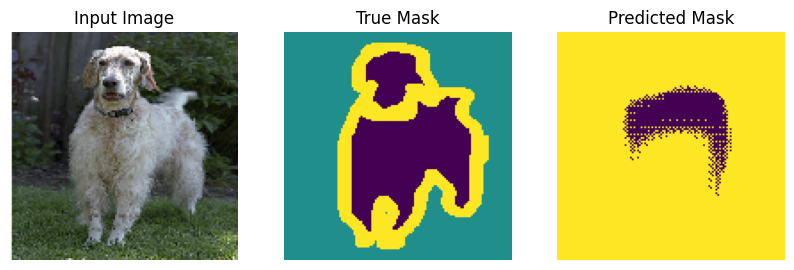

115/115 ━━━━━━━━━━━━━━━━━━━━ 50s 439ms/step - accuracy: 0.6708 - loss: 0.7869 - val_accuracy: 0.6766 - val_loss: 0.7978
Epoch 3/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 40s 347ms/step - accuracy: 0.7171 - loss: 0.7170 - val_accuracy: 0.6874 - val_loss: 0.7774
Epoch 4/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - accuracy: 0.7362 - loss: 0.6736Generating visualizations after epoch 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


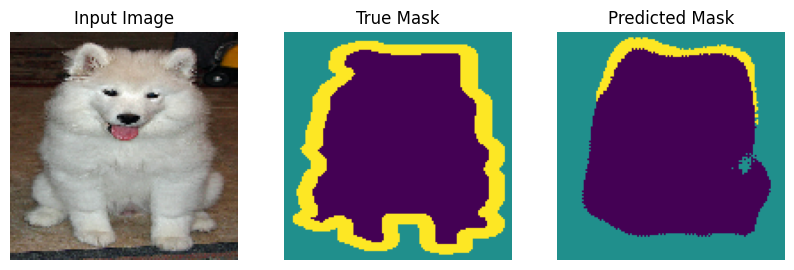

115/115 ━━━━━━━━━━━━━━━━━━━━ 51s 442ms/step - accuracy: 0.7364 - loss: 0.6732 - val_accuracy: 0.7813 - val_loss: 0.5567
Epoch 5/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 40s 348ms/step - accuracy: 0.7863 - loss: 0.5470 - val_accuracy: 0.8098 - val_loss: 0.4846
Epoch 6/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - accuracy: 0.8075 - loss: 0.4909Generating visualizations after epoch 6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


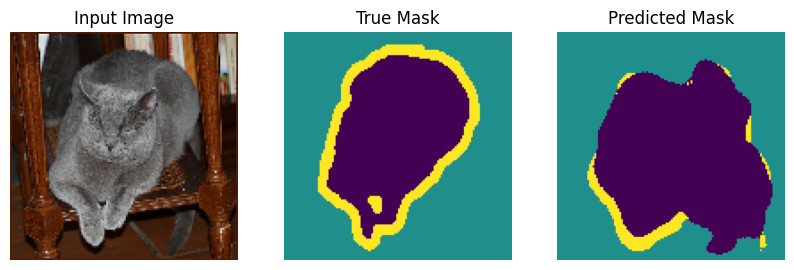

115/115 ━━━━━━━━━━━━━━━━━━━━ 49s 430ms/step - accuracy: 0.8075 - loss: 0.4909 - val_accuracy: 0.8159 - val_loss: 0.4738
Epoch 7/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 41s 353ms/step - accuracy: 0.8195 - loss: 0.4631 - val_accuracy: 0.8058 - val_loss: 0.4954
Epoch 8/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - accuracy: 0.8261 - loss: 0.4458Generating visualizations after epoch 8
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


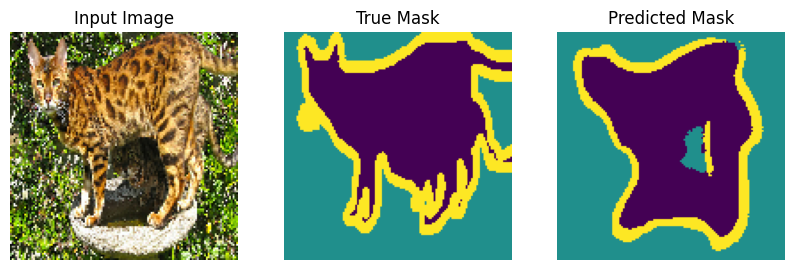

115/115 ━━━━━━━━━━━━━━━━━━━━ 51s 443ms/step - accuracy: 0.8261 - loss: 0.4458 - val_accuracy: 0.8343 - val_loss: 0.4295
Epoch 9/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 41s 354ms/step - accuracy: 0.8412 - loss: 0.4092 - val_accuracy: 0.8397 - val_loss: 0.4095
Epoch 10/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - accuracy: 0.8507 - loss: 0.3836Generating visualizations after epoch 10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


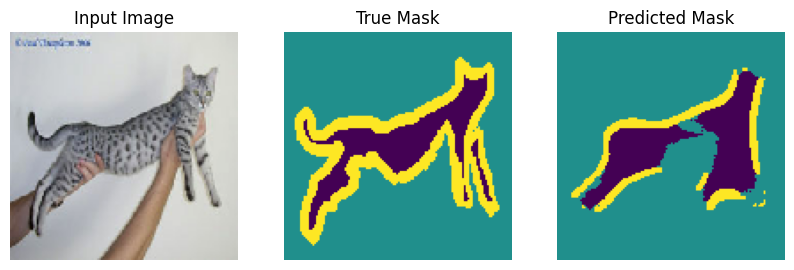

115/115 ━━━━━━━━━━━━━━━━━━━━ 50s 434ms/step - accuracy: 0.8506 - loss: 0.3836 - val_accuracy: 0.8448 - val_loss: 0.4074
Epoch 11/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 42s 365ms/step - accuracy: 0.8565 - loss: 0.3693 - val_accuracy: 0.8517 - val_loss: 0.3830
Epoch 12/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - accuracy: 0.8614 - loss: 0.3549Generating visualizations after epoch 12
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


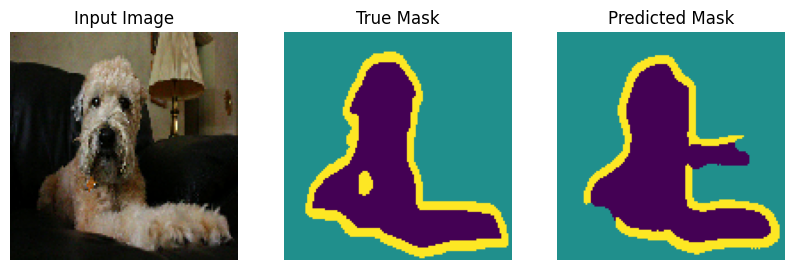

115/115 ━━━━━━━━━━━━━━━━━━━━ 52s 454ms/step - accuracy: 0.8614 - loss: 0.3549 - val_accuracy: 0.8480 - val_loss: 0.3939
Epoch 13/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 41s 359ms/step - accuracy: 0.8660 - loss: 0.3461 - val_accuracy: 0.8571 - val_loss: 0.3706
Epoch 14/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - accuracy: 0.8733 - loss: 0.3231Generating visualizations after epoch 14
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


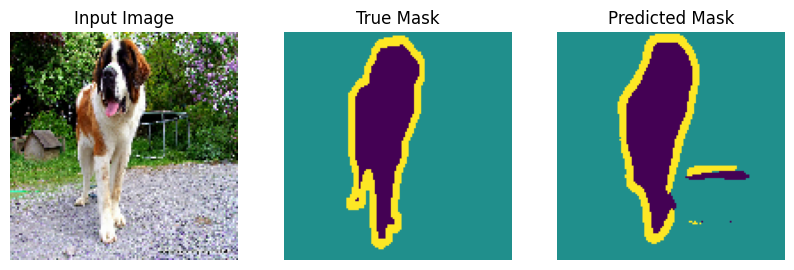

115/115 ━━━━━━━━━━━━━━━━━━━━ 51s 448ms/step - accuracy: 0.8733 - loss: 0.3231 - val_accuracy: 0.8510 - val_loss: 0.3964
Epoch 15/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 41s 356ms/step - accuracy: 0.8797 - loss: 0.3105 - val_accuracy: 0.8620 - val_loss: 0.3687
Epoch 16/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - accuracy: 0.8878 - loss: 0.2871Generating visualizations after epoch 16
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


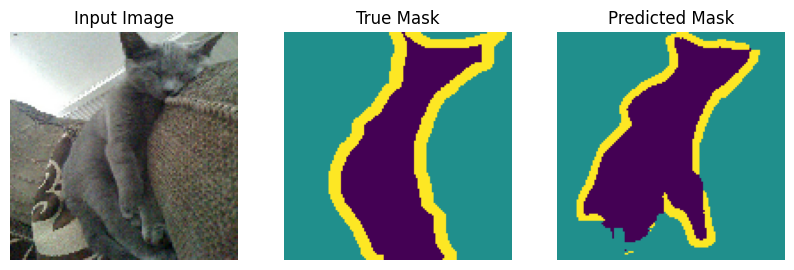

115/115 ━━━━━━━━━━━━━━━━━━━━ 50s 434ms/step - accuracy: 0.8877 - loss: 0.2872 - val_accuracy: 0.8569 - val_loss: 0.3819
Epoch 17/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 41s 355ms/step - accuracy: 0.8899 - loss: 0.2805 - val_accuracy: 0.8650 - val_loss: 0.3519
Epoch 18/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - accuracy: 0.8954 - loss: 0.2678Generating visualizations after epoch 18
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


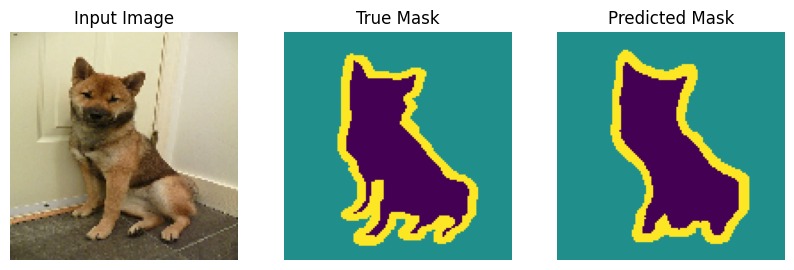

115/115 ━━━━━━━━━━━━━━━━━━━━ 51s 443ms/step - accuracy: 0.8953 - loss: 0.2679 - val_accuracy: 0.8648 - val_loss: 0.3691
Epoch 19/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 41s 356ms/step - accuracy: 0.9021 - loss: 0.2483 - val_accuracy: 0.8629 - val_loss: 0.3754
Epoch 20/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - accuracy: 0.9052 - loss: 0.2389Generating visualizations after epoch 20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


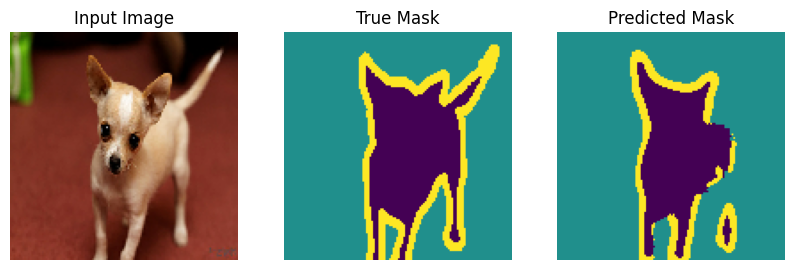

115/115 ━━━━━━━━━━━━━━━━━━━━ 51s 442ms/step - accuracy: 0.9052 - loss: 0.2389 - val_accuracy: 0.8458 - val_loss: 0.4619


In [36]:
# Обучение модели с использованием обратного вызова
model_history = unet_model.fit(train_dataset,
                               epochs=EPOCHS,
                               steps_per_epoch=STEPS_PER_EPOCH,
                               validation_steps=VALIDATION_STEPS,
                               validation_data=test_dataset,
                               callbacks=[visualization_callback])

In [37]:
# Оценка модели
loss, accuracy = unet_model.evaluate(test_dataset, steps=VALIDATION_STEPS)
print(f"Точность на тестовом наборе данных: {accuracy}")

114/114 ━━━━━━━━━━━━━━━━━━━━ 11s 99ms/step - accuracy: 0.8466 - loss: 0.4550
Точность на тестовом наборе данных: 0.8458464741706848


Удаление пропускных связей между путями сжатия и расширения привело к увеличению ошибки сегментации и времени обучения модели